In [358]:
import pandas as pd
import numpy as np
from scipy.sparse import hstack
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.model_selection import GridSearchCV

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression

from sklearn.neural_network import MLPClassifier

In [2]:
train = pd.read_csv('final_train.csv')

#Completo los NaN que se generan al importar del CSV
train.update(train[['hashtags', 'mentions', 'urls', 'clean_text', 'punctuation_signs', 'lemma_text', 'porter_stemmed_text', 'snowball_stemmed_text']].fillna(""))

test = train.loc[train['source'] == 'test']
train = train.loc[train['source'] == 'train']

In [307]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7503 entries, 0 to 7502
Data columns (total 35 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   id                        7503 non-null   int64  
 1   keyword                   7503 non-null   object 
 2   location                  5028 non-null   object 
 3   text                      7503 non-null   object 
 4   target                    7503 non-null   float64
 5   country                   7503 non-null   object 
 6   city                      7503 non-null   object 
 7   lat                       4273 non-null   float64
 8   lon                       4273 non-null   float64
 9   source                    7503 non-null   object 
 10  words                     7503 non-null   object 
 11  real_words                7503 non-null   object 
 12  clean_text                7503 non-null   object 
 13  punctuation_signs         7503 non-null   object 
 14  hashtags

In [3]:
def generateSubmission(predicts, model):
    submission = test[['id', 'target']]
    submission['target'] = predicts
    submission['target'] = submission['target'].astype(int)
    submission.to_csv(model + '_pred.csv', index=False)

In [4]:
train_numeric = train[['entities_count', 'words_count', 'punctuations_signs_count', 'hashtags_count', 'mentions_count', 'urls_count', 
           'stopwords_count', 'words_length_avg', 'punctuations_ratio', 'mentions_ratio', 'urls_ratio', 'stopwords_ratio',
           'special_entities_ratio', 'keyword_cv_mean_enc']]

## TFIDF

In [277]:
def tfIdfVectorization(df, columnName, ngram_range=(1, 1), min_df=1):
    return TfidfVectorizer(sublinear_tf=True, ngram_range=ngram_range, min_df=min_df, norm='l2').fit(np.array(train['text']))

## BOW

In [265]:
def bowVectorization(df, columnName, min_df=5):
    return CountVectorizer(min_df=min_df).fit(np.array(df[columnName]))

In [122]:
def transformVector(vector, df, columnName):
    return vector.transform(np.array(df[columnName]))

### Prueba TFIDF todo junto

In [341]:
def executeTest(name='test', testing=True, model='nb'):
    text_vector = tfIdfVectorization(train, 'text', min_df=5)
    hashtags_vector = bowVectorization(train, 'hashtags', min_df=1)
    mentions_vector = bowVectorization(train, 'mentions', min_df=5)
    realwords_vector = tfIdfVectorization(train, 'real_words', min_df=5)
    
    transformed_text_vector = transformVector(text_vector, train, 'text')
    transformed_hashtags_vector = transformVector(hashtags_vector, train, 'hashtags')
    transformed_mentions_vector = transformVector(mentions_vector, train, 'mentions')
    transformed_realwords_vector = transformVector(realwords_vector, train, 'real_words')
    XT = hstack((transformed_text_vector, transformed_hashtags_vector, transformed_mentions_vector, transformed_realwords_vector))
    y = np.array(train['target'])
    X_train, X_test, y_train, y_test = train_test_split(XT, y, test_size=0.2, random_state=30)
    
    if model == 'nb':
        nb_model = MultinomialNB()
        if testing:
            nb_model.fit(X_train, y_train)
            predicts = nb_model.predict(X_test)
            print("Score NB:", f1_score(y_test, predicts))
        else:
            nb_model.fit(XT, y)
            predicts = nb_model.predict(X_test)
            text_vector_test = transformVector(text_vector, test, 'text')
            hashtags_vector_test = transformVector(hashtags_vector, test, 'hashtags')
            mentions_vector_test = transformVector(mentions_vector, test, 'mentions')
            realwords_vector_test = transformVector(realwords_vector, test, 'real_words')
            XT_r = hstack((text_vector_test, hashtags_vector_test, mentions_vector_test, realwords_vector_test))
            subm = nb_model.predict(XT_r)
            generateSubmission(subm, 'nb_' + name)
    else :
        lr_model = LogisticRegression(solver='liblinear')
        if testing:
            lr_model.fit(X_train, y_train)
            predicts = lr_model.predict(X_test)
            print("Score LR:", f1_score(y_test, predicts))
        else:
            lr_model.fit(XT, y)
            predicts = lr_model.predict(X_test)
            text_vector_test = transformVector(text_vector, test, 'text')
            hashtags_vector_test = transformVector(hashtags_vector, test, 'hashtags')
            mentions_vector_test = transformVector(mentions_vector, test, 'mentions')
            realwords_vector_test = transformVector(realwords_vector, test, 'real_words')
            XT_r = hstack((text_vector_test, hashtags_vector_test, mentions_vector_test, realwords_vector_test))
            subm = lr_model.predict(XT_r)
            generateSubmission(subm, 'lr_' + name)

In [346]:
executeTest(model='lr', testing=False, name='real_words')

C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [337]:
text_vector = tfIdfVectorization(train, 'text', min_df=5)
hashtags_vector = bowVectorization(train, 'hashtags', min_df=1)
mentions_vector = bowVectorization(train, 'mentions', min_df=5)
realwords_vector = tfIdfVectorization(train, 'real_words', min_df=5)

In [338]:
transformed_text_vector = transformVector(text_vector, train, 'text')
transformed_hashtags_vector = transformVector(hashtags_vector, train, 'hashtags')
transformed_mentions_vector = transformVector(mentions_vector, train, 'mentions')
transformed_realwords_vector = transformVector(realwords_vector, train, 'real_words')
XT = hstack((transformed_text_vector, transformed_hashtags_vector, transformed_mentions_vector, transformed_realwords_vector))
y = np.array(train['target'])
X_train, X_test, y_train, y_test = train_test_split(XT, y, test_size=0.2, random_state=30)

In [339]:
## NaiveBayes
nb_model = MultinomialNB()
#nb_model.fit(XT, y)
nb_model.fit(X_train, y_train)
predicts = nb_model.predict(X_test)
print("Score NB:", f1_score(y_test, predicts))

Score NB: 0.7627118644067795


In [340]:
## Logistic Regression
lr_model = LogisticRegression(solver='liblinear')
lr_model.fit(X_train, y_train)
predicts = lr_model.predict(X_test)
print("Score LR:", f1_score(y_test, predicts))

Score LR: 0.7653490328006729


In [204]:
text_vector_test = transformVector(text_vector, test, 'text')
hashtags_vector_test = transformVector(hashtags_vector, test, 'hashtags')
mentions_vector_test = transformVector(mentions_vector, test, 'mentions')
XT_r = hstack((text_vector_test, hashtags_vector_test, mentions_vector_test))
subm = nb_model.predict(XT_r)
generateSubmission(subm, 'nb_tfidf_bow_tunned')

C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [101]:
#Predigo para lo real
x1_r = text_vector.transform(np.array(test['lemma_text']).ravel())
x2_r = hashtags_vector.transform(np.array(test['hashtags']).ravel())
x3_r = mentions_vector.transform(np.array(test['mentions']).ravel())
x4_r = urls_vector.transform(np.array(test['urls']).ravel())
XT_r = hstack((x1_r, x2_r, x3_r, x4_r))

AttributeError: transform not found

In [ ]:
subm = nb_model.predict(XT_r)

In [ ]:
generateSubmission(subm, 'nb_full')

## RandomForest

In [ ]:
def randomForestGridSearch():
    X_train, X_test, y_train, y_test = train_test_split(train_numeric.values, train['target'].values, test_size=0.2, random_state=530)
    
    rf_folds = 5
    rf_grid = dict(n_estimators=[3, 6, 9, 12], max_depth=[4, 8, 12], min_samples_split=[15, 30, 45, 60], min_samples_leaf=[15, 30, 45, 60], max_features=[5, 10, 13])
    clf = GridSearchCV(estimator=RandomForestClassifier(random_state=51), param_grid=rf_grid, n_jobs=-1, cv=rf_folds, scoring='f1', error_score=0)
    clf.fit(X_train, y_train)
    print("Mejores parametros encontrados:", clf.best_params_)

    rf_best_model = RandomForestClassifier(random_state=51, n_estimators=clf.best_params_['n_estimators'], max_features=clf.best_params_['max_features'], min_samples_leaf=clf.best_params_['min_samples_leaf'], min_samples_split=clf.best_params_['min_samples_split'], max_depth=clf.best_params_['max_depth'])
    rf_best_model.fit(X_train, y_train)
    preds = rf_best_model.predict(X_test)
    print("Score RF:", f1_score(y_test, preds))
    
    print(train_numeric.columns)
    print(rfModel.feature_importances_)
    
    return preds

In [ ]:
print(train_numeric.columns)
print(rfModel.feature_importances_)

## Naive Bayes

In [ ]:
def naiveBayesGridSearch(columnName):
    vector = tdfIdfVectorization(columnName)
    
    X = vector.transform(np.array(train[columnName]).ravel())
    y = np.array(train['target']).ravel()
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=30)
    
    nb_model = MultinomialNB()
    nb_model.fit(X_train, y_train)
    predicts = nb_model.predict(X_test)
    print("Score NB:", f1_score(y_test, predicts))
    
    return predicts

In [ ]:
naiveBayesGridSearch('lemma_text')

## Logistic Regression

In [54]:
#values para 1 columna: np.array(train[columnName]).ravel()
def logisticRegressionGridSearch(values):
    vector = TfidfVectorizer(sublinear_tf=True)
    vector.fit(values)
    
    X = vector.transform(values)
    y = np.array(train['target']).ravel()
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=30)
    
    lr_folds = 10
    lr_grid = dict(solver=['liblinear', 'lbfgs', 'saga'], penalty=['l1', 'l2', 'elasticnet'], C=[0.5, 0.75, 1.0, 1.25, 1.5])
    clf = GridSearchCV(estimator=LogisticRegression(random_state=51), param_grid=lr_grid, n_jobs=-1, cv=lr_folds, scoring='f1', error_score=0)
    clf.fit(X_train, y_train)
    
    print("Best params:", clf.best_params_)
    
    predicts = clf.predict(X_test)
    print("Score LR:", f1_score(y_test, predicts))
    
    return predicts

In [58]:
def logisticRegressionFullGridSearch(XT):
    y = np.array(train['target']).ravel()
    X_train, X_test, y_train, y_test = train_test_split(XT, y, test_size=0.2, random_state=30)
    
    lr_folds = 10
    lr_grid = dict(solver=['liblinear', 'lbfgs', 'saga'], penalty=['l1', 'l2', 'elasticnet'], C=[1.5, 1.55, 1.65, 1.70])
    clf = GridSearchCV(estimator=LogisticRegression(random_state=51), param_grid=lr_grid, n_jobs=-1, cv=lr_folds, scoring='f1', error_score=0)
    clf.fit(X_train, y_train)
    
    predicts = clf.predict(X_test)
    print("Score LR:", f1_score(y_test, predicts))
    
    print("Best params:", clf.best_params_)
    
    return predicts

In [59]:
logisticRegressionGridSearch(np.array(train['lemma_text']).ravel())

Best params: {'C': 1.5, 'penalty': 'l2', 'solver': 'liblinear'}
Score LR: 0.7397020157756354


array([0., 1., 0., ..., 1., 1., 0.])

In [60]:
logisticRegressionGridSearch(np.array(train['porter_stemmed_text']).ravel())

Best params: {'C': 1.5, 'penalty': 'l2', 'solver': 'lbfgs'}
Score LR: 0.7445887445887446


array([0., 1., 0., ..., 1., 1., 0.])

In [53]:
logisticRegressionGridSearch(np.array(train['snowball_stemmed_text']).ravel())

Score LR: 0.7422145328719724


array([0., 1., 0., ..., 1., 1., 0.])

In [52]:
logisticRegressionFullGridSearch(XT)

Score LR: 0.741514360313316


array([0., 1., 0., ..., 1., 1., 0.])

## Perceptron

In [364]:
def multilayerPerceptron(props):
    #mp_folds = 5
    #mp_grid = dict(hidden_layer_sizes=[100], max_iter=[300], activation=['tanh'], solver=['sgd'], learning_rate=['constant'])
    #clf = GridSearchCV(estimator=MLPClassifier(random_state=51), param_grid=mp_grid, n_jobs=-1, cv=mp_folds, scoring='f1', error_score=0)
    #clf.fit(X_train, y_train)
    clf = MLPClassifier(max_iter=props['max_iter'], hidden_layer_sizes=props['hidden_layer_sizes'], activation=props['activation'], solver=props['solver'])
    clf.fit(X_train, y_train)

    #print("Best params:", clf.best_params_)
    
    predicts = clf.predict(X_test)
    print("Score Perceptron:", f1_score(y_test, predicts))
    
    plt.ylabel('Costo')
    plt.xlabel('Iteraciones')
    plt.title("Curva de aprendizaje")
    plt.plot(clf.loss_curve_)
    plt.show()

In [353]:
multilayerPerceptron(dict(max_iter=300, hidden_layer_sizes=(100), activation='tanh', solver='sgd'))

Score Perceptron: 0.7504273504273503


C:\ProgramData\Miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Score Perceptron: 0.7527801539777587


C:\ProgramData\Miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


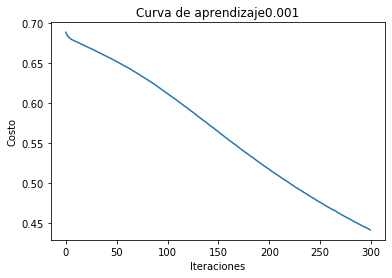

In [367]:
multilayerPerceptron(dict(max_iter=300, hidden_layer_sizes=(500), activation='tanh', solver='sgd'))